In [38]:
# Para mas información, consulta el GitHub [https://github.com/Zygmut/Practica_3_IA]
# Autores: Palmer Pérez, Rubén; Torres Torres, Marc; Orr, Kieran Donal

# Setup
Importamos todos los paquetes necesarios para la práctica. 

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier 

Creamos un conjunto de variables para facil acceso y cambio de parámetros

In [40]:
TEST_SIZE = 0.33             # Proportion for test size in relation to the dataset
ALTERNATIVE_MODE = False     # Quality (0-10) or ("bad", "average", "good")
QUALITY_THRESHOLD = 6        # Threshold that defines a range for each quality of wine ("bad", "average", "good")

Definimos una variable `DEBUG` (y su método de uso) que, en caso de estar activada, nos dará información adicional a lo largo de la ejecución del proyecto 

In [41]:
DEBUG = True 

def debugPrint(string):
    if DEBUG : print(f"[🐛] {string}")

# El dataset
Cargamos los datasets y les añadimos la columna `type` que nos permitara reconocer de que tipo son una vez juntados los datasets. Si `type = 0` el vino será blanco, de lo contrario sera rojo.

In [42]:
white = pd.read_csv("dataset/winequality-white.csv", sep=';')
white.insert(0, 'type', 0)
red = pd.read_csv("dataset/winequality-red.csv", sep= ';')
red.insert(0, 'type', 1)
df = pd.concat([white, red])
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Preparamos los datos del dataset eliminando todos los posibles valores nulos y transformando los valores que no sean `np.float64` o `np.int64` 

In [43]:
# Preparacion del dataset

labelencoder = LabelEncoder()

if not df[df.isna().any(axis=1)].shape[0] == 0 :
    debugPrint("Valores nulos eliminados para el dataframe")
    
df.dropna(inplace=True) # Eliminacion de valores nullos

for column in df.columns: # Transformar posibles valores no numericos
    if not df[column].dtype in (np.float64, np.int64):
        df[column] = labelencoder.fit_transform(df[column])
        debugPrint(f"Los valores de {column} se han transformado a numericos")


## Visualización de datos
En este apartado visualizaremos los datos para un entendimiento gráfico de nuestras carácteres.

Primero visualizaremos la disposición de nuestros datos con respecto a la **calidad**

<AxesSubplot:xlabel='quality', ylabel='count'>

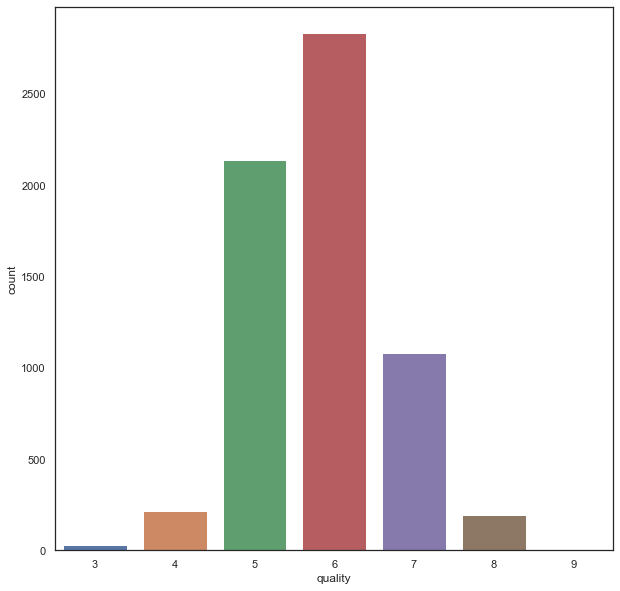

In [44]:
plt.figure(figsize=(10,10))
sns.set(style="white")
sns.countplot(x=df["quality"])

Como podemos ver aqui los datos estan distribuidos como una distribución normal, hay muchos datos por el centro en los valores de 5, 6 y 7 y pocos datos en los extremos. Eso es de esperar con una muestra de tamaño tan grande pero, el hecho de que haya tan pocos datos en los extremos nos va a causar problemas luego a la hora de hacer las predicciones sino categorizamos.  

Otra representación que puede ser interesante sería poder ver la diferencia de calidad entre los vinos tintos y los vinos blancos

<AxesSubplot:xlabel='quality', ylabel='count'>

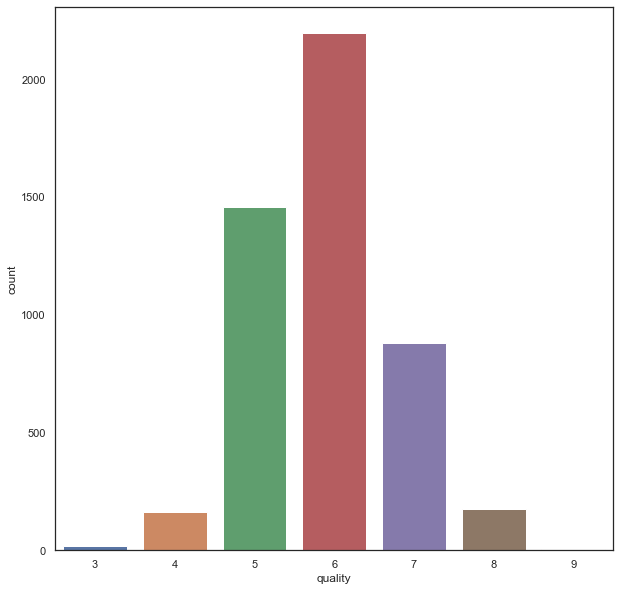

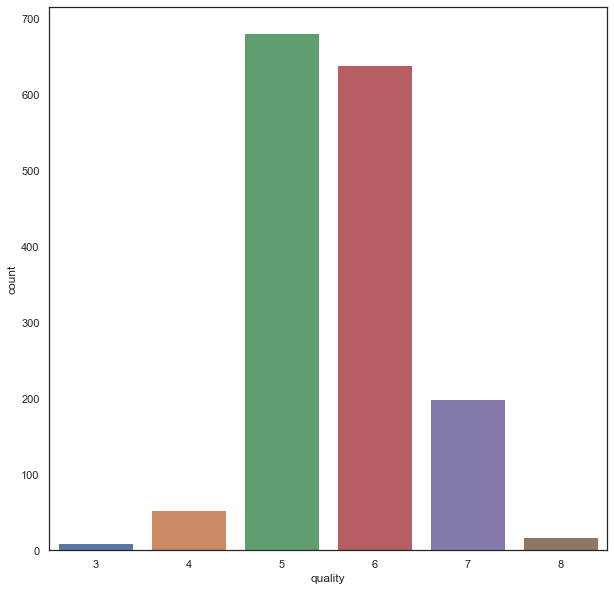

In [45]:
plt.figure(figsize=(10,10))
sns.set(style="white")
sns.countplot(x=white["quality"])

plt.figure(figsize=(10,10))
sns.set(style="white")
sns.countplot(x=red["quality"])

Podemos observar que, ademas de tener muchas mas muestras en el vino blanco, el vino tinto suele tener notas más bajas. Podemos calcular una media rápidamente para poder reasegurarlo.

In [46]:
print("Media de los vinos blancos: {}\t Media de los vinos tintos: {}".format(np.mean(white["quality"]), np.mean(red["quality"])))

Media de los vinos blancos: 5.87790935075541	 Media de los vinos tintos: 5.6360225140712945


## Matriz de correlación
Como ya hemos visto en la visualización de los datos tenemos caracteristicas que, respecto a calidad, no nos ofrecen mucha variación. Para asegurarnos de esta independecia entre caracteristicas, analizaremos la matriz de correlación. 

<AxesSubplot:>

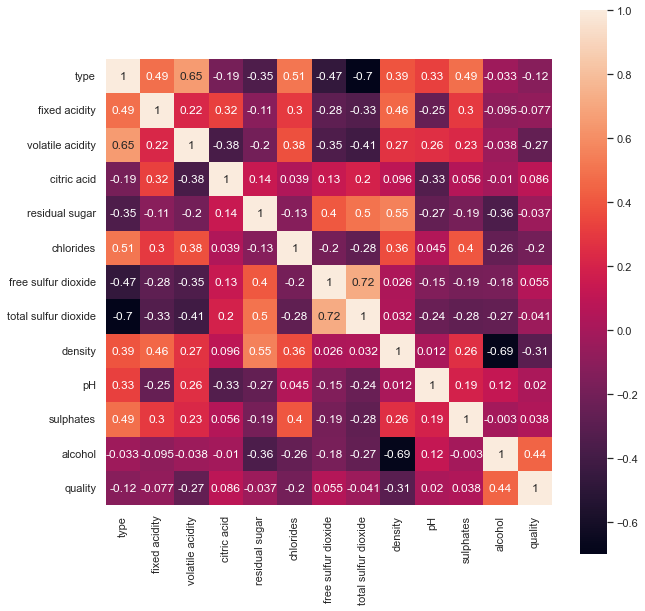

In [47]:
fig = plt.figure(figsize=(10,10))

sns.heatmap(df.corr(), annot=True, square=True)


En la matriz de correlación podemos ver como hay ciertos elememtos que influyen muy poco con su puntuación. Por ahora las vamos a seguir utilizando pero en el siguiente apartado no las vamos a tener en cuenta.

Adicionalmente, definiremos unos rangos de calidad de tal manera que :
- baja &rarr; "quality" < `QUALITY_THRESHOLD` 
- media &rarr; "quality" = `QUALITY_THRESHOLD` 
- alta &rarr; "quality" > `QUALITY_THRESHOLD` 

Lo tomaremos tal que:
- baja &rarr; 1 
- media &rarr; 2
- alta &rarr; 3

In [48]:
if ALTERNATIVE_MODE :
    debugPrint("Alternative mode detected")
    df["quality"] = df["quality"].apply(lambda y: 1 if y<QUALITY_THRESHOLD else y)
    df["quality"] = df["quality"].apply(lambda y: 2 if y==QUALITY_THRESHOLD else y)
    df["quality"] = df["quality"].apply(lambda y: 3 if y>QUALITY_THRESHOLD else y)

debugPrint(df["quality"].unique())

[🐛] [6 5 7 8 4 3 9]


Poder juntar las puntuaciones en categorias nos ayudara mucho a la hora de hacer predicciones ya que puntuaciones como el 9 tiene solo 5 ejemplos, hacer predicciones con una muestra tan pequeña resulta ser difícil. Pero si los juntamos con lo 8 y 7 nos da mas data para hacer tests.

## Escalado de datos
Por último, escalamos los datos y separamos las "features" y etiquetas

In [49]:
m_M_scaler = preprocessing.MinMaxScaler()

# Separamos las features de las etiquetas 
y = df["quality"]
x = df.drop("quality", axis=1)

# Escalamos los datos
x = m_M_scaler.fit_transform(x)


### Separación del conjunto de entrenamiento, validación y testeo
Una vez obtenido nuestro dataset con sus valores procesados, creamos los 2 subconjuntos de datos que nos permitirán entrenar nuestros modelos (entrenamiento y testeo). El subconjutno de validación se creará posteriormente.

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=TEST_SIZE, stratify=y , random_state=42)

# Modelos
Una vez preparado nuestros datasets de entrenamiento y testeo, podemos usarlos para nuestros modelos de machine learning

In [51]:
# Definimos las etiquetas
targetType = ["bad", "average", "good"]

## Aplicación

Podemos observar que para la solución cuya salida es una nota tenemos varias `zero_division`. Esto ocurre debido a una desproporción de datos. Esto se podría solucionar si tuviesemos más datos para todas las posibles calidades de nuestro dataset. Para esta solución, en vez de generar datos a partir de los actuales mediante algún tipo de interpolación, trataremos estas `zero_division` como 1 

### Regresión logística
Debemos aumentar las `max_iter` ya que el número de iteraciónes base (100) no es suficiente

In [52]:
clr = LogisticRegression(random_state=0, max_iter=200).fit(x_train, y_train) # Aumentamos las iteraciónes 
y_hat = clr.predict(x_test)

if ALTERNATIVE_MODE:
    print(classification_report(y_test, y_hat, target_names=targetType))
else: 
    print(classification_report(y_test, y_hat, zero_division=1)) # Evitamos el error de "división por zero" 

              precision    recall  f1-score   support

           3       1.00      0.00      0.00        10
           4       1.00      0.00      0.00        71
           5       0.58      0.61      0.60       706
           6       0.53      0.72      0.61       936
           7       0.50      0.19      0.28       356
           8       1.00      0.00      0.00        64
           9       1.00      0.00      0.00         2

    accuracy                           0.55      2145
   macro avg       0.80      0.22      0.21      2145
weighted avg       0.57      0.55      0.51      2145



### Perceptron

In [53]:
cp = Perceptron(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)

if ALTERNATIVE_MODE:
    print(classification_report(y_test, y_hat, zero_division=1, target_names=targetType))
else: 
    print(classification_report(y_test, y_hat, zero_division=1)) # Evitamos el error de "división por zero" 

              precision    recall  f1-score   support

           3       1.00      0.00      0.00        10
           4       1.00      0.00      0.00        71
           5       0.49      0.75      0.59       706
           6       0.50      0.58      0.54       936
           7       1.00      0.00      0.00       356
           8       1.00      0.02      0.03        64
           9       1.00      0.00      0.00         2

    accuracy                           0.50      2145
   macro avg       0.86      0.19      0.17      2145
weighted avg       0.62      0.50      0.43      2145



### Random forest

In [54]:
crf = RandomForestClassifier(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)

if ALTERNATIVE_MODE:
    print(classification_report(y_test, y_hat , zero_division=1, target_names=targetType))
else: 
    print(classification_report(y_test, y_hat, zero_division=1)) # Evitamos el error de "división por zero" 

              precision    recall  f1-score   support

           3       1.00      0.00      0.00        10
           4       1.00      0.00      0.00        71
           5       0.49      0.75      0.59       706
           6       0.50      0.58      0.54       936
           7       1.00      0.00      0.00       356
           8       1.00      0.02      0.03        64
           9       1.00      0.00      0.00         2

    accuracy                           0.50      2145
   macro avg       0.86      0.19      0.17      2145
weighted avg       0.62      0.50      0.43      2145



## Analisis de los resultados

En los tres modelos podemos ver resultados similares cuando utilizamos la classificación por numeros.

 En regressión logística vemos que solo predice puntuaciones de 5, 6 y 7. Esto es debido a que son las muestras mas grandes por tanto son las puntuaciones con los que hemos entrenado mas, en cambio el total de muestras de las otras es mas pequeño que las muestras de la puntuación 7 esto hace que se realice poco entrenamiento con esos valores. Por culpa de esto en la regression lineal, no se classifica ningún valor en 3, 4, 8 y 9. El hecho de que no se predice ningun valor para estas puntaciones nos va a resultar en una abundancia de falsos positivos, que lo podemos ver en nuestra precision baja en general (Aparte de los de 3, 4, 8 y 9 que es 1 porque se hace una división de 0/0). Pero en cambio no esta tan baja el recall al menos para las puntuaciones de 6 y 5. Con estas dos eran los que tenian la mayor cantidad de datos con diferencia nos han dado pocos falsos negativos resultando en un recall alto. Para las puntuaciones de 3, 4, 7, 8 y 9 podemos ver un recal muy baja debido a que son de datasets pequeños y no se esta prediciendo ningun valor paras ellos.

 Para el perceptron y el random forest los resultados son identicos solo predice valores para las puntuaciones de 5 y 6 (Los dos sets mas grandes). Ocurre lo mismo que en la regresion lineal hay valores que no los percibe esos son por lo mismo que hemos dicho antes, son de las muestras mas pequeñas, por eso no predice nada para esas puntuaciones. Los que si que predice 5 y 6 si que predice pero tiene una precision muy baja por lo dicho antes, se le estan asignandod muchos falsos positivos. Lo interesante es ver que los recals si que han cambiado respecto a la regression lineal ahora el 5 ha augmentado en su recal y el 6 ha disminuido. Eso sera porque se le esta dando menos falsos negativos para 5 y esta dando mas para 6.

Cuando realizamos la classificacion por average, bad y good vemos que los 3 modelos cambian:

 Para la regression logística podemos ver que los resultados siguen sin ser muy precisos pero esta vez se predicen de todas las clases pero seguimos con una baja precisiion el que lo tiene mas alto es la clase de baja y solo tiene un 64% los otros dos estan alrededor del 50%. El recall tiene el mismo problema es relativamente baja sobretodo en el caso de los buenos que es de un 30%. Pero aun asi es mejor que cuando hacemos la regresion logística con los numeros como clases. Ya que agrupando las clases ha resultado en muestras para cada uno de las classes mas grandes.

 Otra vez por perceptron y random forest volvemos a ver que tienen los mismos resultados pero esta vez ha pasado una cosa diferente al respecto de separar las clases por numeros, no predice ningún valor para la clase de average. Esta vez no podemos decir que es porque la muestra de la clase es demasiada pequeña, de hecho es la más grande. Esta vez no esta poniendo nada en la categoria de average porque las variables de average los esta poniendo en las otras dos. Esto podria ser resultado variables que esta teniendo en cuenta a la hora de predecir que no deberia porque influyen demasiado poco.